In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi   #Checking the gpu

Mon Aug 30 09:00:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    69W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Checking the version of tensorflow
tf.__version__

'2.6.0'

In [4]:
#Importing the required libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.chdir('drive/MyDrive/plant_data')   #Changing the path directory to our dataset folder location

In [7]:
!pwd   #Checking the path directory

/content/drive/MyDrive/plant_data


In [8]:
#Re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/plant_data/train'   #Path of train dataset
valid_path = '/content/drive/My Drive/plant_data/test'    #Path of test dataset

In [9]:
#Import the ResNet50 library as shown below and add preprocessing layer to the front
#Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [10]:
#Don't train the existing weights as it is a pre-trained model and we will be training our last layer alone
for layer in resnet.layers:
    layer.trainable = False

In [11]:
#Getting the number of output classes
folders = glob('/content/drive/My Drive/plant_data/train/*')

In [12]:
#We are flattening it so that we can add any number of layers in the last node
x = Flatten()(resnet.output)

In [13]:
#Checking the length of folders
len(folders)

4

In [14]:
#Predicting the data using length of folders and activation function used is softmax as there are more than 2 categories
prediction = Dense(len(folders), activation='softmax')(x)

#Creating a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [15]:
#Checking the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
#Compiling the model with loss, optimitizer and metrics value
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
#Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Train data
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

#Test data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
#Make sure you provide the same target size as initialied for the image size
#Reading the number of images in train dataset
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/plant_data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [19]:
#Reading the number of images in test dataset
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/plant_data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [20]:
#Fit the model
r = model.fit(training_set, validation_data=test_set, epochs=20, steps_per_epoch=len(training_set), validation_steps=len(test_set))

Epoch 1/20
61/61 [==============================] - 711s 12s/step - loss: 2.9427 - accuracy: 0.4167 - val_loss: 1.6451 - val_accuracy: 0.5000
Epoch 2/20
61/61 [==============================] - 44s 716ms/step - loss: 0.9981 - accuracy: 0.5864 - val_loss: 1.0364 - val_accuracy: 0.5556
Epoch 3/20
61/61 [==============================] - 44s 715ms/step - loss: 1.0317 - accuracy: 0.5802 - val_loss: 0.7685 - val_accuracy: 0.7778
Epoch 4/20
61/61 [==============================] - 44s 715ms/step - loss: 0.9289 - accuracy: 0.6525 - val_loss: 0.7728 - val_accuracy: 0.7222
Epoch 5/20
61/61 [==============================] - 44s 717ms/step - loss: 1.0062 - accuracy: 0.6233 - val_loss: 0.8113 - val_accuracy: 0.6667
Epoch 6/20
61/61 [==============================] - 44s 719ms/step - loss: 0.6958 - accuracy: 0.7340 - val_loss: 0.8287 - val_accuracy: 0.7778
Epoch 7/20
61/61 [==============================] - 44s 720ms/step - loss: 1.0391 - accuracy: 0.6412 - val_loss: 0.7405 - val_accuracy: 0.7222


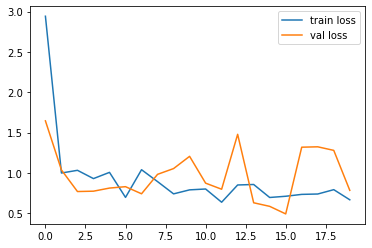

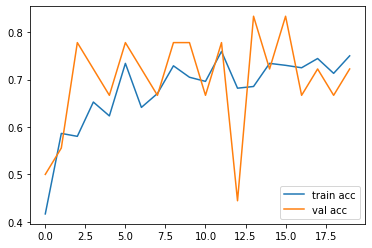

<Figure size 432x288 with 0 Axes>

In [21]:
#Plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#Plotting the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [22]:
#Saving it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
#Prediction using test set
y_pred = model.predict(test_set)

In [24]:
y_pred

array([[1.87328458e-02, 9.28524077e-01, 8.07383377e-03, 4.46691923e-02],
       [2.18672620e-04, 9.92814004e-01, 1.01449405e-05, 6.95710303e-03],
       [2.43806513e-03, 6.83134854e-01, 3.84891629e-02, 2.75937885e-01],
       [1.61348376e-02, 6.47874724e-04, 1.45161133e-02, 9.68701243e-01],
       [2.93497345e-03, 7.00074388e-03, 9.88371074e-01, 1.69324409e-03],
       [8.66644783e-04, 7.65896738e-01, 2.32852884e-02, 2.09951386e-01],
       [5.07233664e-03, 2.03119516e-01, 4.05120142e-02, 7.51296103e-01],
       [6.78987068e-04, 5.12903631e-01, 8.20409786e-03, 4.78213280e-01],
       [2.40621448e-04, 9.92554247e-01, 4.14975034e-03, 3.05535109e-03],
       [9.15624481e-03, 9.08165932e-01, 7.39347190e-02, 8.74308404e-03],
       [4.58239723e-04, 9.76543367e-01, 9.08708479e-03, 1.39113562e-02],
       [2.27992207e-01, 7.42670596e-01, 6.00193022e-03, 2.33352166e-02],
       [9.94035363e-01, 2.06201184e-06, 5.20407083e-03, 7.58473470e-04],
       [2.57993379e-04, 9.98635590e-01, 9.57889915e